# Optics Functions FCC-ee 

Notebook to study the optical functions of FCC-ee
* [Data Input](#DtInpt)
* [Machine Parameters](#mchPrmts)
* [1. SAD Output](#SDotpt)
* [1.1 Beam Envelope](#bet_xy)
* [1.2 Dispersion](#disp_xy)
* [2. MAD-X Output](#mdx)
* [2.1 Machine Geometry - Survey](#mdxSrv)
* [2.2 Closed Orbit](#ClsdOrbt)
* [2.3 Beta Function](#BtFct)
* [2.4 Beam Envelope](#BmEnvlp)
* [2.5 Beam Divergence](#BmDvrgc)
* [3 Match SAD and MAD Output](#mtchSdMd)
* [3.1 Beta Beating](#BtBeat)

In [1]:
%reset
# import general libs (probably not required)
#
import matplotlib as mpl
import matplotlib.pyplot as plt 
from numpy import cos, sin, sqrt, array, abs
import pandas as pd
from os.path import expanduser
from IPython.core.display import display, HTML

# change to source dir to import specific stuff
#
%cd ~/Codes/Python/FCC-ee/source/
import VisualSpecs
from VisualSpecs import myColors as colors
from VisualSpecs import align_yaxis, adjust_yaxis
from TfsTables import TfsReader, PlotOptics
from DF_Tools import OutputToDF
from Input import readParams
from Tools import sbplSetUp, inventAper
from CS_to_EU import ToEuclidian
from Plot import Plot_Bend_Cones

# temporarily disable the SetCopies warning:
# pd.options.mode.chained_assignment = None

# %reload_ext autoreload

# %aimport TfsTables, Input, OpticsSelectTools, Plot, PlotSetup

# %autoreload 1
%matplotlib inline

# some general parameters (top energy)
m0 = 511e-6
E0 = 182.5
if E0 == 45.6:
    Nbun = 16640; Np = 1.7e11
    sigZ = 3.5e-3
    epsX = .27e-9; epsY = 1e-12
    sigmPSR = .038/100 # energy spread due to synchrotron radiation
    sigmPBS = .132/100 # energy spread due to beamstrahlung
elif E0 == 182.5:
    Nbun = 48; Np = 2.3e11
    sigZ = 1.97e-3
    epsX = 1.46e-9; epsY = 2.9e-12
    sigmPSR = .150/100 # energy spread due to synchrotron radiation
    sigmPBS = .192/100 # energy spread due to beamstrahlung

else: raise RuntimeError('Beam energy unknown!')
HalfCrossingAngle = 0.015
Lrnt = E0/m0
brho = 10*E0/2.9979
particle = "positron"

print("---- Beam Parameters b1 ---- \n", " Beam energy =", E0, 'with', Nbun, 'bunches/beam with population of', Np, 'particles \n', 'bunch length (SR) =', sigZ, "m",
      "\n emittance x,y =", epsX, epsY, "m",
      "\n Brho =", brho, "\n Lorentz gamma =", Lrnt, 
     "\n ----------------------------- " )


home = expanduser("~")
basepath = home + '/Codes/Projects/FCC-ee-lattice/MadX/output/' + str(E0) + '/'
plotpath = '/tmp/'

display(HTML("<style>.container { width:100% !important; }</style>"))

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
/home/nikita/Codes/Python/FCC-ee/source
---- Beam Parameters b1 ---- 
  Beam energy = 182.5 with 48 bunches/beam with population of 230000000000.0 particles 
 bunch length (SR) = 0.00197 m 
 emittance x,y = 1.46e-09 2.9e-12 m 
 Brho = 608.7594649588045 
 Lorentz gamma = 357142.85714285716 
 ----------------------------- 


#### List contents in the MAD-X output folder -- recent and up to date?

In [3]:
!ls -l ~/Codes/Projects/FCC-ee-lattice/MadX/output/45.6/

insgesamt 0


## 2 Machine Parameters <a class="anchor" id="mchPrmts"></a>

In [2]:
file = home + '/PhD/Notes/IRDesign/data/FCCeeParamList.xlsx'
FCCeeParams = readParams(file)
FCCeeParams

,parameter,Z,W,H (ZH),ttbar,ttbar.1
0,beam energy [GeV],46,80,120,175,1.8e+02
1,arc cell optics,60/60,90/90,90/90,90/90,90/90
2,momentum compaction [E-5],1.5,0.73,0.73,0.73,0.73
3,horizontal emittance [nm],0.27,0.28,0.63,1.3,1.4
4,vertical emittance [pm],1,1,1.3,2.7,2.7
5,horizontal beta* [m],0.15,0.2,0.3,1,1
6,vertical beta* [mm],0.8,1,1,2,2
7,length interaction area [mm],0.42,0.5,0.9,1.9,2
8,"tunes, half-ring (x,y,s)","(0.569,0.61,0.0125)","(0.577,0.61,0.0115)","(0.565,0.60,0.0180)","(0.553,0.59,0.0343)","(0.553, 0.59, 0.0350)"
9,longitudinal damping time [ms],414,77,23,7.5,6.6


## 1 SAD Output <a class="anchor" id="SDotpt"></a>
-- Not yet here --

## 2 MAD-X Output<a class="anchor" id="mdx"></a>
MAD-X is operating with a sequence translated from SAD. For the translation, several attributes have been droppend and bends readjusted to close the ring. But the optic wasn't rematched.

Initial TWISS without start values for $\beta_{x,y}$ fails. MAD-X doesn't find a solution. TWISS with intial conditions finds solution but seems off already at start (see below, $\beta_{x,y}$ at IP).

In [2]:
# SAD_Twiss = TfsReader(home + '/Codes/MadX/translator/sler_sad_twiss.tfs').read_sad( relS = 1, verbose = 0 )
MAD_Twiss = TfsReader( basepath + 'fcc_ee_b1_twiss.tfs' ).read_twiss( verbose = 0, relS = 1) 
# MAD_Twiss = TfsReader( '/tmp/fcc_ee_b1_twiss.tfs' ).read_twiss( verbose = 0, relS = 1 )
# MAD_Twiss_init = TfsReader( basepath + 'fcc_ee_b1_i_twiss.tfs' ).read_twiss( verbose = 0, relS = 1 )

MAD_Survey_b1 = TfsReader( basepath + 'fcc_ee_b1_survey.tfs').read_survey( verbose = 1 )
MAD_Survey_b2 = TfsReader( basepath + 'fcc_ee_b2_survey.tfs').read_survey( verbose = 1 )
MAD_Survey_b1['xRot'] = MAD_Survey_b1['X']*cos(-HalfCrossingAngle) + MAD_Survey_b1['Z']*sin(-HalfCrossingAngle) 
MAD_Survey_b1['zRot'] = -MAD_Survey_b1['X']*sin(-HalfCrossingAngle) + MAD_Survey_b1['Z']*cos(-HalfCrossingAngle) 

 Add column 'rel_S' -- S position shifted with IP in the center. Using Lmax =  97756.06428319066
----------------------------------
 DF contains: 
 Index(['S', 'X', 'Y', 'Z', 'THETA', 'PHI', 'PSI'], dtype='object') 
 data tpes are: 
 S        float64
X        float64
Y        float64
Z        float64
THETA    float64
PHI      float64
PSI      float64
dtype: object
----------------------------------
----------------------------------
 DF contains: 
 Index(['S', 'X', 'Y', 'Z', 'THETA', 'PHI', 'PSI'], dtype='object') 
 data tpes are: 
 S        float64
X        float64
Y        float64
Z        float64
THETA    float64
PHI      float64
PSI      float64
dtype: object
----------------------------------


### Manipulate the TWISS
Adding parameters like EU coordinates and PS

In [4]:
ToEuclidian( MAD_Twiss, verbose = 0 )

MAD_Twiss['APER'] = MAD_Twiss[['rel_S', 'NAME', 'APER_1']].apply( lambda x: inventAper( *x ), axis = 1 )
MAD_Twiss['PS'] = 1 - sqrt(MAD_Twiss.PX**2 + MAD_Twiss.PY**2)

twissInstnc = PlotOptics( MAD_Twiss, plotpath )

selection zmin = -800 zmax = 0 m


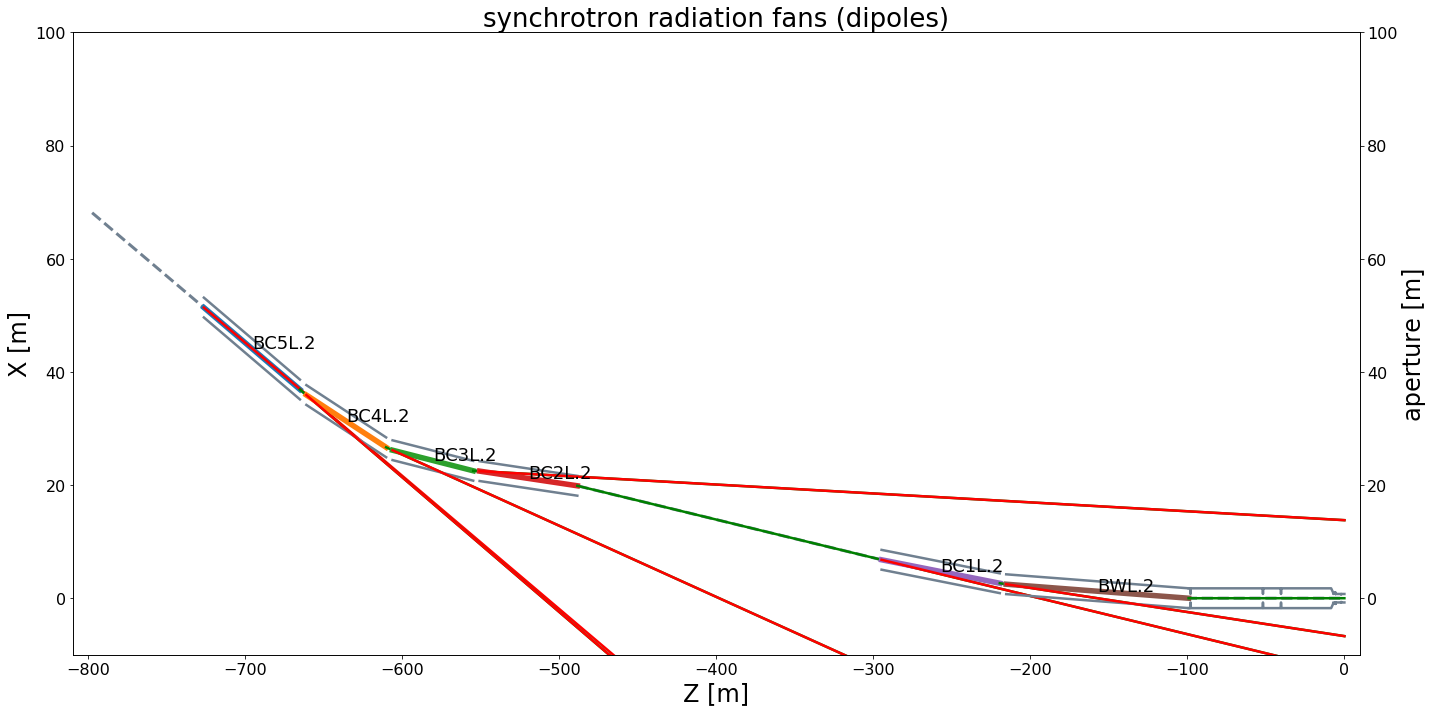

In [7]:
entry = Plot_Bend_Cones( MAD_Twiss, 50, aper = 1, zrange = [-800,0], xrange=[-10,100], verbose = 0)
# plt.savefig( plotpath + "SRlstBendsZ400.pdf", dpi = 70 )
# exit = Plot_Bend_Cones( MAD_Twiss, 50, aper = 1, zrange = [-620, 10], xrange=[-2,40] )
# plt.savefig( plotpath + "SRlst4bendsAperColl.pdf", dpi = 100 )

### 2.1 Machine Geometry - Survey<a class="anchor" id="mdxSrv"></a>

#### Entrance to the IR
Plot the section from IP outwards back upstream until the first or second bend. This way, get a plot like the LEP plots with enhanced transverse aperture vs. S (or Z?).
Compare with old LEP plots as below
![alt text](LEP_SRcoll.png "Title")

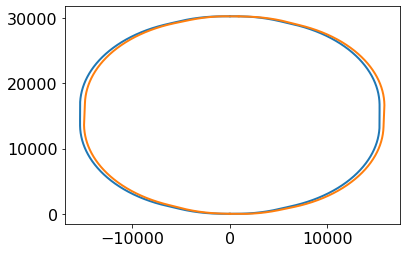

In [45]:
plt.figure()
plt.plot( -MAD_Survey_b1.Z,-MAD_Survey_b1.X )
plt.plot(  MAD_Survey_b2.Z,  MAD_Survey_b2.X )
# plt.xlim(-3000, 3000)
# plt.ylim(-200, 50)

### 2.2 Apertures

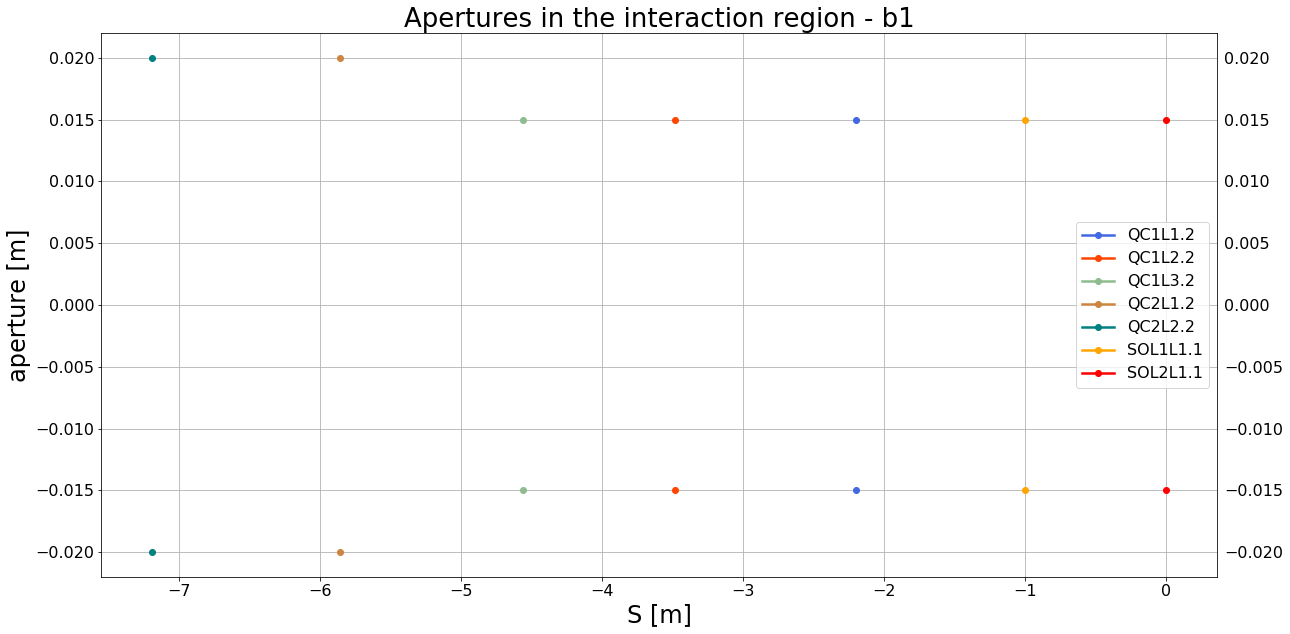

In [11]:
IRmagnetList = ['QC1L1.2','QC1L2.2','QC1L3.2','QC2L1.2','QC2L2.2','SOL1L1.1','SOL2L1.1']#,'QC1R1.1','QC1R2.1','QC1R3.1','QC2R1.2','QC2R2.2','SOL1R1.1','SOL2R1.1']

k = 0
plt.figure( figsize = (20,10) )
ax = plt.axes()

for magnet in IRmagnetList:
    plt.plot(MAD_Twiss[MAD_Twiss.NAME.str.startswith(magnet)].rel_S, 
             MAD_Twiss[MAD_Twiss.NAME.str.startswith(magnet)].APER_1, label = magnet, color = colors[k], marker = 'o', lw = 2.5 ) 
    plt.plot(MAD_Twiss[MAD_Twiss.NAME.str.startswith(magnet)].rel_S,
             -MAD_Twiss[MAD_Twiss.NAME.str.startswith(magnet)].APER_1, color = colors[k], marker = 'o', lw = 2.5, label = '')
    k += 1
    
ax.arrow(-1, -0.04, 2, 0, head_width = 2.5e-3, head_length = 0.3, color = 'red', linewidth = 1.5, fill = False, label = '$e^+$')
plt.xlabel('S [m]'); plt.ylabel('aperture [m]')
plt.tick_params(labeltop = False, labelright = True)
plt.legend()
plt.grid()
plt.title('Apertures in the interaction region - b1');

### 2.3 Beta Function<a class="anchor" id="BtFct"></a>

#### Without solenoid and without initial conditions, RF off.

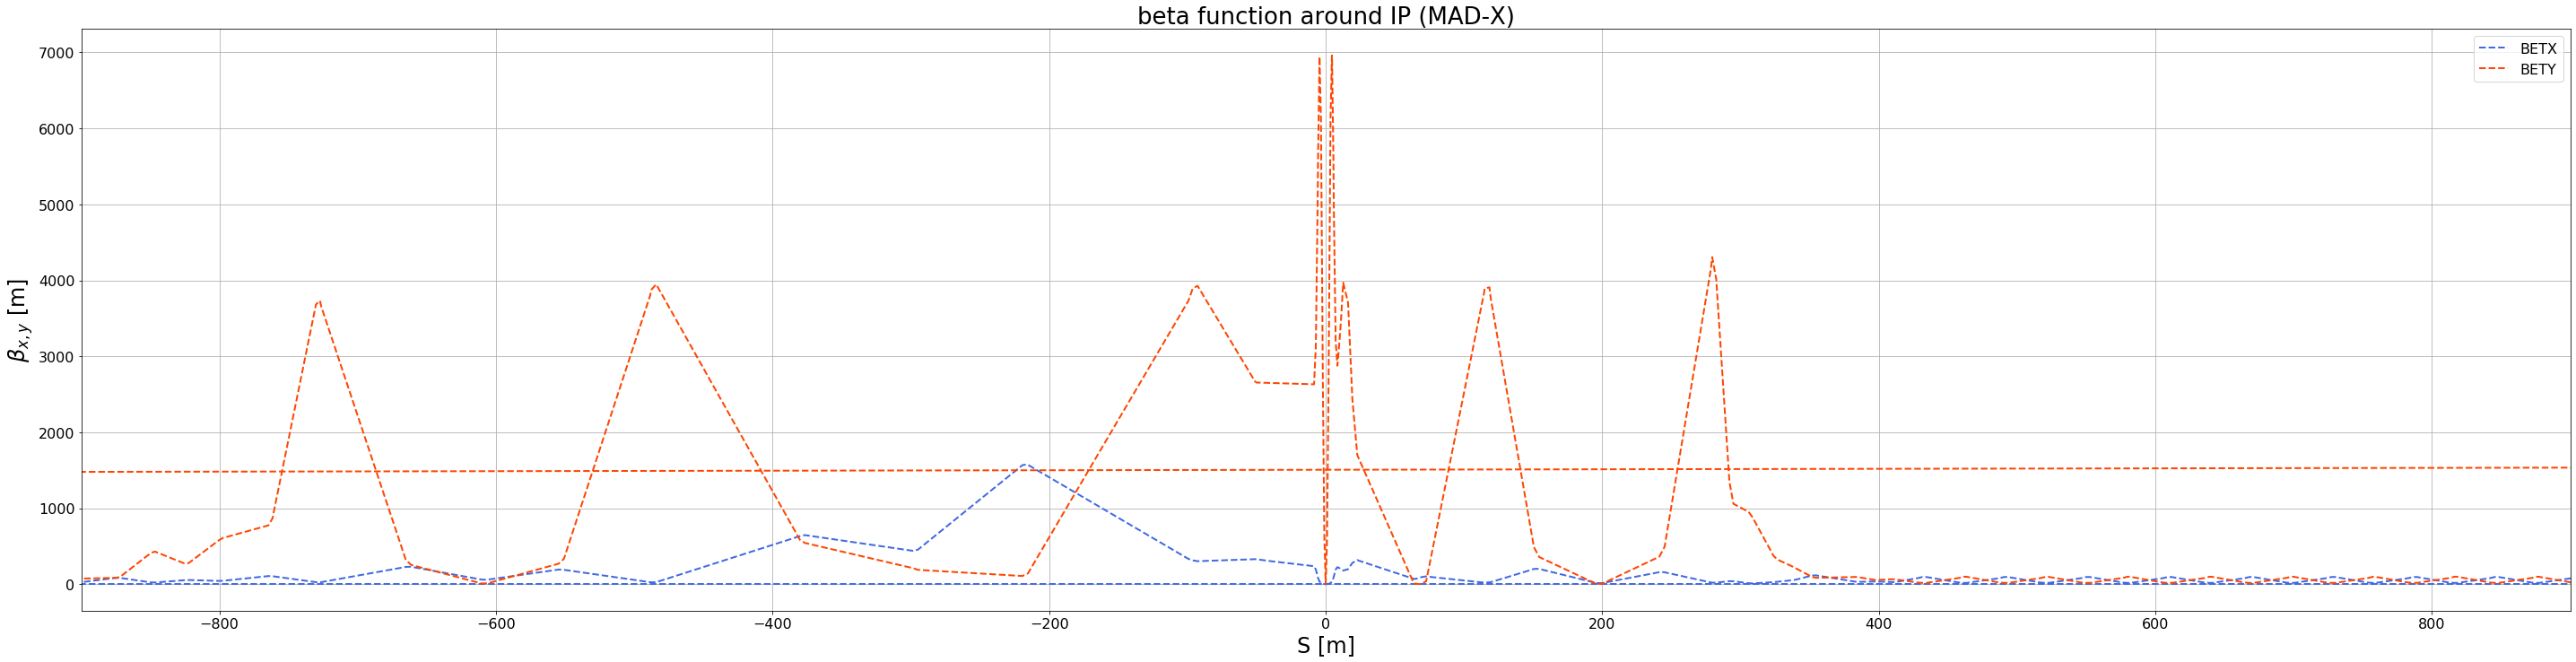

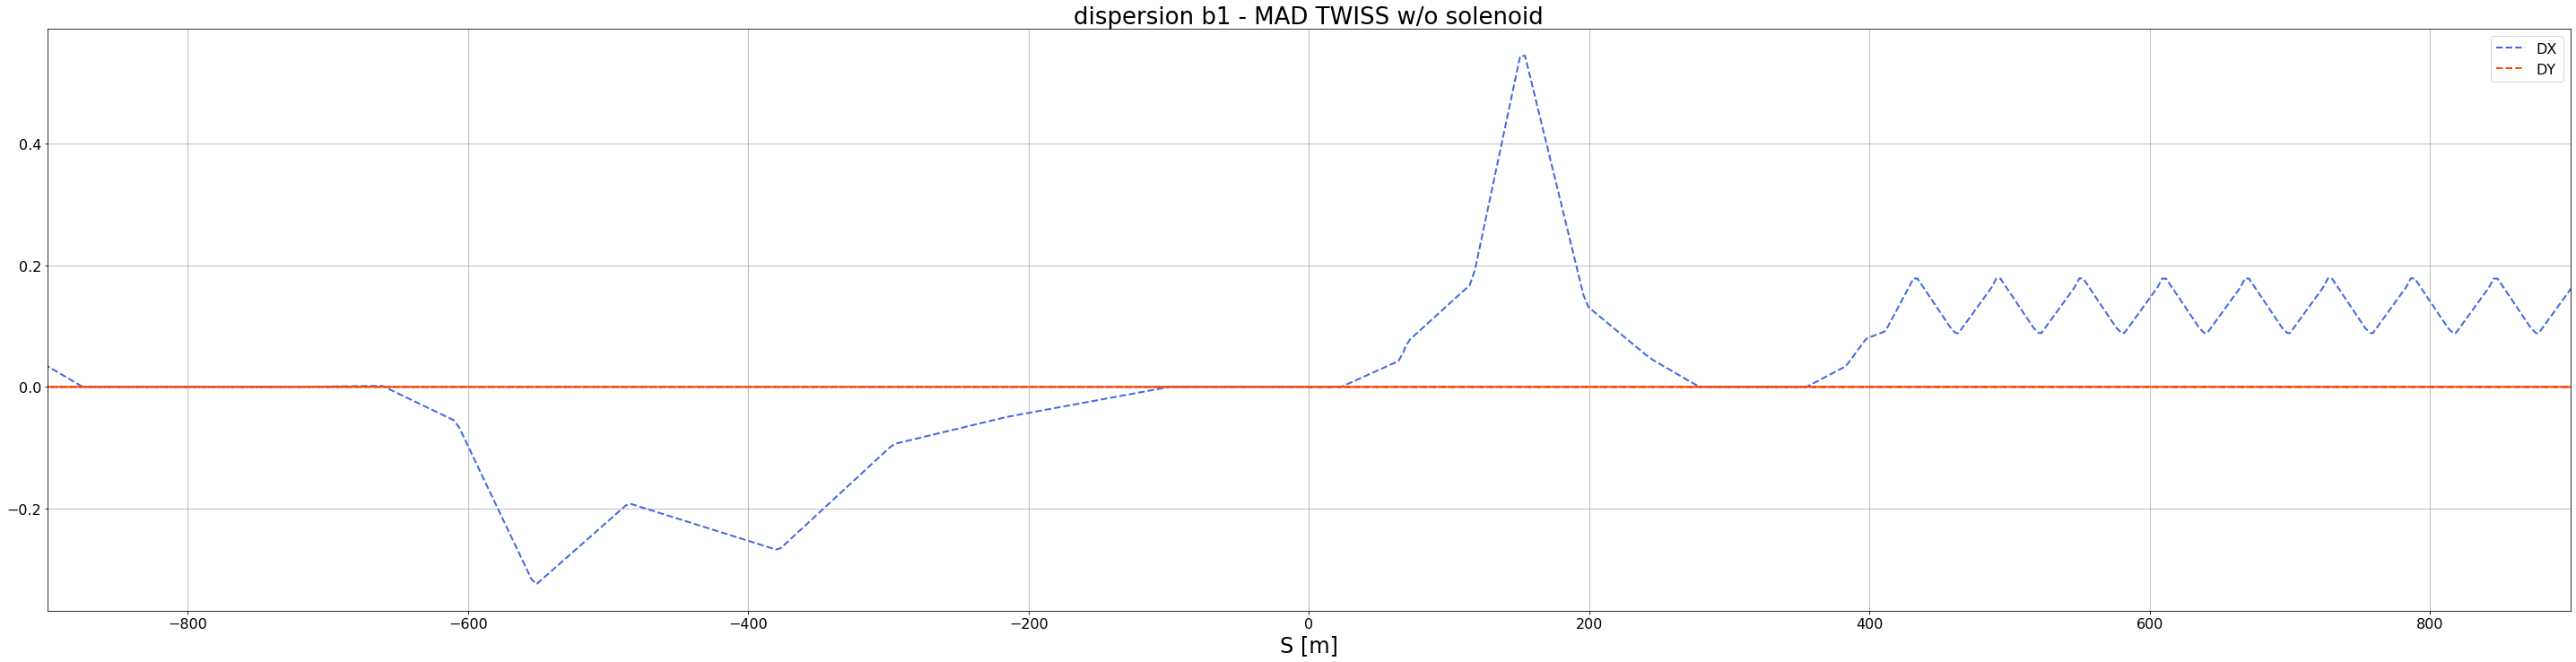

In [9]:
# MADtws = twissInstnc.plotTwissParams( twissPara = ["BETX","BETY"], verbose = 1)
# plt.xlabel('S [m]'); plt.tight_layout()
# plt.title('beta function b1 - MAD')
# # plt.xlim(10e3,12e3); plt.ylim(0,100)
# plt.ylabel('$\\beta_{x,y}$ [m]')
# # plt.savefig( plotpath + "MAD_beta_function_ler.pdf", dpi = 150 )

MADtwsIP = twissInstnc.plotTwissParams( twissPara = ["BETX","BETY"], relS = 1)
plt.xlim(-900,900)
plt.grid()
plt.ylabel('$\\beta_{x,y}$ [m]')
plt.xlabel('S [m]'); plt.tight_layout()
plt.title('beta function around IP (MAD-X)');
plt.savefig( plotpath + "MADbeta_fctIP.pdf", dpi = 90 )

MADtwsDsp = twissInstnc.plotTwissParams( twissPara = ["DX",'DY'], relS = 1, verbose = 1 )
plt.xlim(-900, 900); plt.grid(); plt.tight_layout()
plt.title('dispersion b1 - MAD TWISS w/o solenoid')
plt.savefig( plotpath + "MADdisp_IP.pdf", dpi = 90 )

#### Detailed look into beam envelope and dispersion.


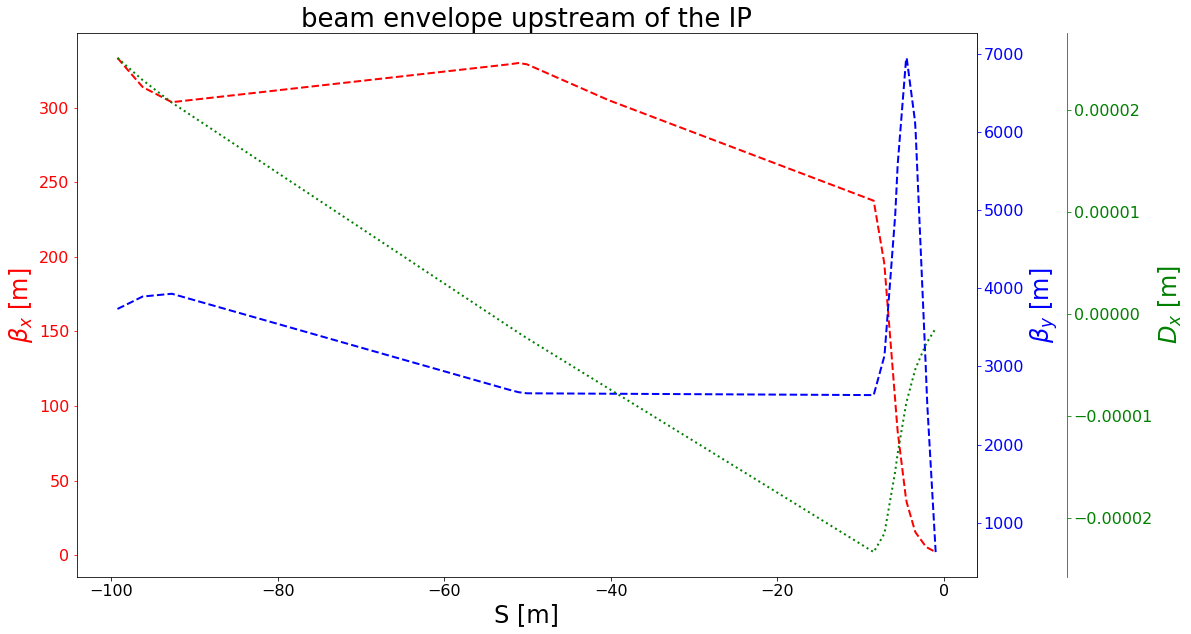

In [14]:
tmpdf = MAD_Twiss[(MAD_Twiss.rel_S>-100) & (MAD_Twiss.rel_S<0)]

# prepare the figure
fig = plt.figure( figsize = (20,10) ); 
host = fig.add_subplot(111)
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

# move the spine of the second axes outwards
par2.spines["right"].set_position(("axes", 1.1))

# plot actual data
p1, = host.plot(tmpdf.rel_S, tmpdf.BETX, 'r--')
p2, = par1.plot(tmpdf.rel_S, tmpdf.BETY, 'b--')
p3, = par2.plot( tmpdf.rel_S, tmpdf.DX, 'g:')

# host.set_xlim(0, 2)
# host.set_ylim(0, 2)
# par1.set_ylim(0, 4)
# par2.set_ylim(1, 65)

# axes labels
host.set_xlabel('S [m]')
host.set_ylabel('$\\beta_x$ [m]')
par1.set_ylabel('$\\beta_y$ [m]')
par2.set_ylabel('$D_x$ [m]')

lines = [p1, p2, p3]
# host.legend(lines, [l.get_label() for l in lines])

for ax in [par1,par2]:
    ax.set_frame_on(True)
    ax.patch.set_visible(False)

    plt.setp(ax.spines.values(), visible=False)
    ax.spines["right"].set_visible(True)

# coloring; cosmetics
host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

par1.spines["right"].set_edgecolor(p2.get_color())
par2.spines["right"].set_edgecolor(p3.get_color())

host.tick_params(axis='y', colors=p1.get_color())
par1.tick_params(axis='y', colors=p2.get_color())
par2.tick_params(axis='y', colors=p3.get_color())
plt.title('beam envelope upstream of the IP');

# plt.savefig( plotpath + 'beta_fct_upstrIP100m.pdf', bbox_inches = 'tight', dpi = 100);

#### With solenoid (initial conditions, RF off)<a class="anchor" id="InitTwss"></a>


In [15]:
MADtwsSol = twissInitInstnc.plotTwissParams( twissPara = ["BETX","BETY"], verbose = 1)
plt.xlabel('S [m]'); plt.tight_layout()
plt.title('beta function b1 - MAD TWISS with init');
# plt.savefig( plotpath + "MAD_beta_function_ler.pdf", dpi = 150 )

MADtwsSolDsp = twissInitInstnc.plotTwissParams( twissPara = ["DX", "DY"], verbose = 1 )
plt.title('dispersion b1 - MAD TWISS w solenoid')

NameError: name 'twissInitInstnc' is not defined

#### Detailed look into beam envelope and dispersion

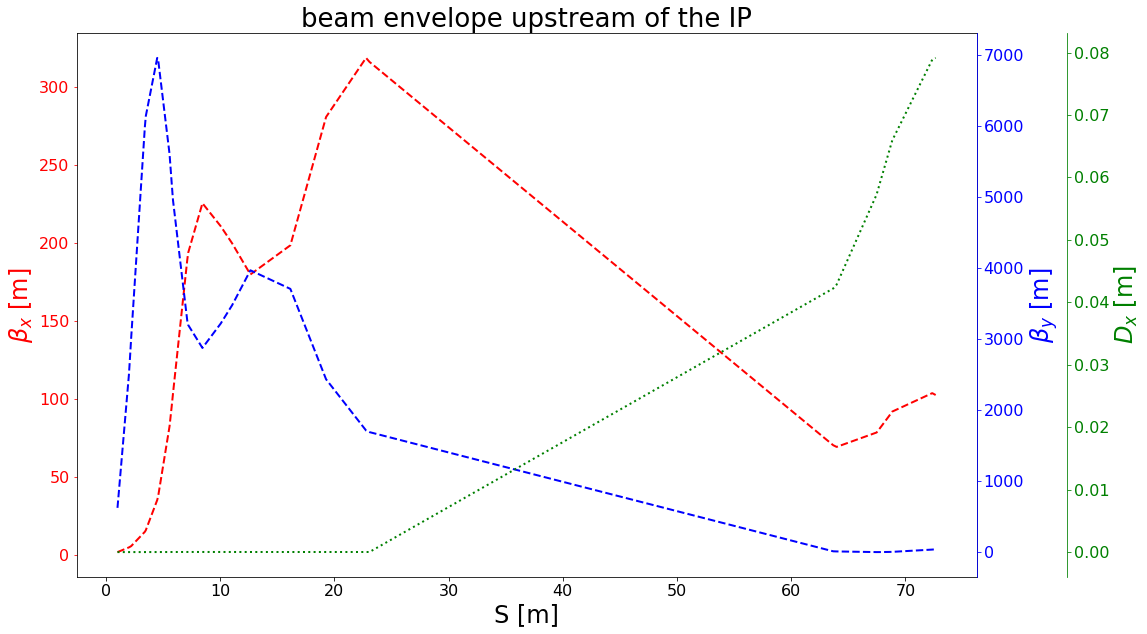

In [17]:
tmpdf = MAD_Twiss[(MAD_Twiss.rel_S>0) & (MAD_Twiss.rel_S<100)]

# prepare the figure
fig = plt.figure( figsize = (20,10) ); 
host = fig.add_subplot(111)
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

# move the spine of the second axes outwards
par2.spines["right"].set_position(("axes", 1.1))

# plot actual data
p1, = host.plot(tmpdf.rel_S, tmpdf.BETX, 'r--')
p2, = par1.plot(tmpdf.rel_S, tmpdf.BETY, 'b--')
p3, = par2.plot( tmpdf.rel_S, tmpdf.DX, 'g:')

# host.set_xlim(0, 2)
# host.set_ylim(0, 2)
# par1.set_ylim(0, 4)
# par2.set_ylim(1, 65)

# axes labels
host.set_xlabel('S [m]')
host.set_ylabel('$\\beta_x$ [m]')
par1.set_ylabel('$\\beta_y$ [m]')
par2.set_ylabel('$D_x$ [m]')

lines = [p1, p2, p3]
# host.legend(lines, [l.get_label() for l in lines])

for ax in [par1,par2]:
    ax.set_frame_on(True)
    ax.patch.set_visible(False)

    plt.setp(ax.spines.values(), visible=False)
    ax.spines["right"].set_visible(True)

# coloring; cosmetics
host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

par1.spines["right"].set_edgecolor(p2.get_color())
par2.spines["right"].set_edgecolor(p3.get_color())

host.tick_params(axis='y', colors=p1.get_color())
par1.tick_params(axis='y', colors=p2.get_color())
par2.tick_params(axis='y', colors=p3.get_color())
plt.title('beam envelope upstream of the IP');

# plt.savefig( plotpath + 'beta_fct_upstrIP.pdf', bbox_inches = 'tight', dpi = 100);

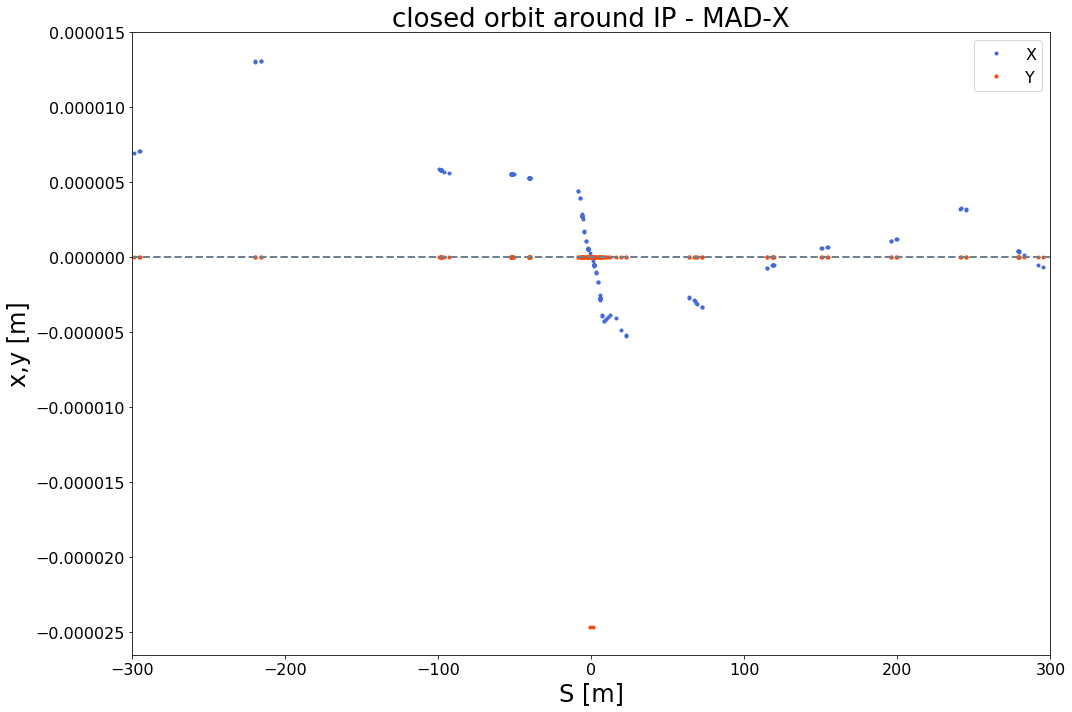

In [6]:
MADPos = twissInstnc.plotTwissParams( twissPara = ['X','Y'], figSize=[15,10], relS = 1)
plt.xlim(-3e2,3e2 ); #plt.ylim(-1e-3,1e-3)
plt.axhline( color = 'slategrey', ls = '--')
plt.title('closed orbit around IP - MAD-X')
plt.ylabel('x,y [m]')
plt.tight_layout()
# plt.savefig( plotpath + "clsdOrbtMAD.pdf", dpi = 100, bbox_to_anchor = 'tight' )

### 2.4 Beam Envelope Plots<a class="anchor" id="BmEnvlp"></a>
Plot the beam envelope with apertures. Useful to find suitable collimator locations. Can also be a helpful when looking at design orbit vs. orbit deviations. 

Collimator settings are based on the beam envelope. That can be estimated (for the horizontal plane) using $$ \begin{equation} \sigma_x = \sqrt{ \beta_x(S)\epsilon_x + \left(D_x(S)\sigma_p\right)^2 } \end{equation} $$
With the beta function $\beta_x$, the nominal emittance $\epsilon_{nom}$, dispersion in the dipoles, $D_x$ and the relative momentum spread $(\sigma_p)_{nom}$. 
The same equation holds for the vertical plane.

Beam sizes at locations without dispersion are simply estimated according to $$ \begin{equation} \sigma_{x,y}(S) = \sqrt{\epsilon_{x,y}\beta(S)} \end{equation}$$

In case of FCC-ee at $t\bar{t}$ (182.5 GeV), we assume for the nominal emittances (maximum current):
* $\epsilon_x$ = 1.46 nm
* $\epsilon_y$ = 2.9 pm
With an energy spread of 
* $\sigma_\delta$ = 0.15 % (Synchrotron Radiation)
* $\sigma_\delta$ = 0.192% (Beam Strahlung)

slected last 100 m upstream. Scale factor = 100.0
maximum aperture found: 0.035


IndexError: list index out of range

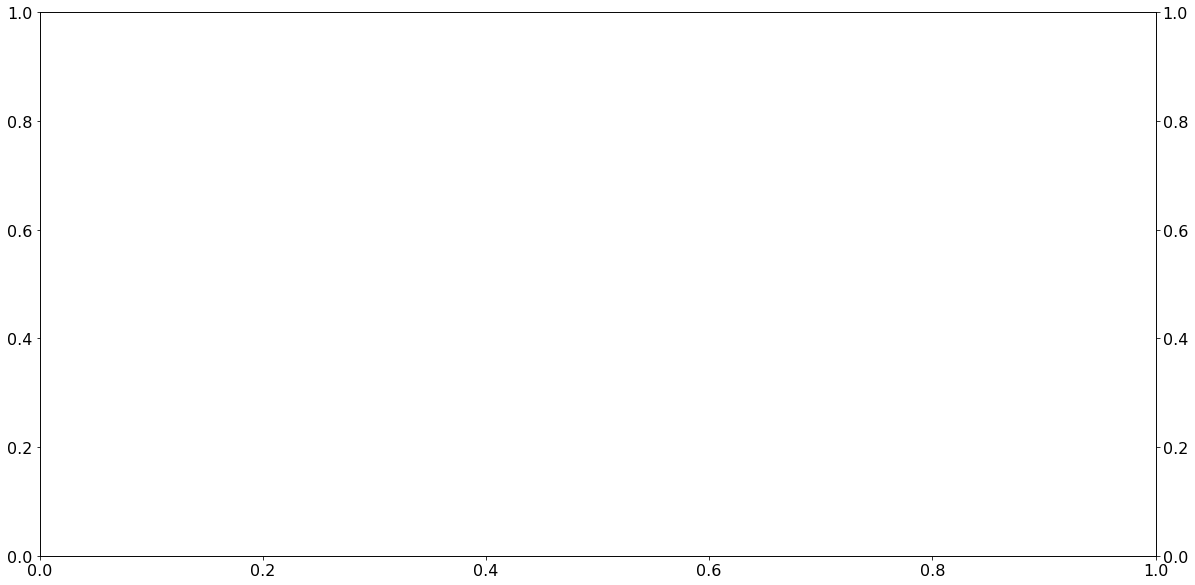

In [18]:
beamSizeX = twissInstnc.plotBeamSize( 100, epsX, sigmPBS )
beamSizeY = twissInstnc.plotBeamSize( 5000, epsY, sigmPBS, plane = 'y' )

In [72]:
# develop a method to plot element representations along the line: bend = rect, quad = line ala MAD-X
#
import matplotlib.patches as patches
Smax = MAD_Twiss_init.S.max()
condition = (MAD_Twiss_init.S > Smax - 250) & (MAD_Twiss_init.S <= Smax)
slFr = MAD_Twiss_init[condition]

fig = plt.figure( figsize = (20,10) ); ax = fig.add_subplot(111)
ax.plot( slFr.S, slFr.APER )
for i in range(slFr.index.min()+1, slFr.index.max()+1):
    Type = slFr.loc[i,'KEYWORD']
    Spos = slFr.loc[i,'S']
    length = Spos-slFr.loc[i-1,'S']
    
    if  'BEND' in Type: print('found bend', length, Spos + length ); ax.add_patch(patches.Rectangle((slFr.loc[i,'S'], .2), Spos + length, .2))
        
    elif 'QUADRUPOLE' in Type: print('found quad')
    elif 'DRIFT' in Type: print('drift space')

NameError: name 'MAD_Twiss_init' is not defined

### 2.5 Beam divergence<a class="anchor" id="BmDvrgc"></a>
Can be estimated according to $\sigma'(s) = \sqrt{\epsilon/\beta(s)}$. This is a local observable and only valid, if $d\beta/dS$ = 0, which is given at the IP or at the center of quadrupoles. 
Hence, below is an estimate of the divergence at the IP for several energy settings at FCC-ee. Assuming that the divergence is largest at the IP, since the beta function is smallest after the low-beta quads.
A more general formula for the divergence is given with $$ \sigma'(s) = \sqrt{\gamma\epsilon}$$ from which the above results as a special case once the slope vanishes. Note, that in this case $\gamma$ is not the Lorentz factor but given by $$ \gamma = \frac{\alpha^2 + 1}{\beta} $$

In [30]:
# define a function to calculate the divergence
#
def div(eps, alf, bet):
    return np.sqrt(eps*(np.abs(alf) + 1)/bet)

## a first estimate using only values at the IP
##
bet = np.array([45.6/m0, 80/m0, 120/m0, 182.5/m0])
betSt = np.array([ [0.15, 0.2, 0.3, 1.0], [1e-3, 0.8e-3, 1.0e-3, 1.6e-3] ])

horEmt = np.array([.27e-9, .84e-9, .63e-9, 1.46e-9])
vrtEmt = np.array([1.0e-12, 1.7e-12, 1.3e-12, 2.9e-12])
params = pd.DataFrame({'beta':bet, 'epsX':horEmt, 'epsY':vrtEmt, 'betStX': betSt[0], 'betStY': betSt[1]})
params['divrgX'] = np.sqrt( params.epsX/params.betStX )
params['divrgY'] = np.sqrt( params.epsY/params.betStY )
print(params)

## do an 'arc-estimate' according to the TWISS above
##
condition = (MAD_Twiss.S >= 10000) & (MAD_Twiss.S <= 20000)
betavg = MAD_Twiss[condition]
BETXmean = betavg.BETX.mean(); BETYmean = betavg.BETY.mean()
ALPXmean = betavg.ALFX.mean(); ALPYmean = betavg.ALFY.mean()
# BETXmax = MAD_Twiss.BETX.max(); BETYmax = MAD_Twiss.BETY.max()
# BETXmin = MAD_Twiss.BETX.min(); BETYmin = MAD_Twiss.BETY.min()

print("\n ========= ARC:"
      "\n mean values between 10 and 20 km:", BETYmean, BETXmean,
      "\n divergence x:", div(horEmt[3], ALPXmean, BETXmean), ", divergence y:", div(vrtEmt[3], ALPYmean, BETYmean), 
      "\n ========= Considering global max/min",
       "\n maxima:", BETXmax, BETYmax, 
      "\n min x-divergence:", np.sqrt(epsX/BETXmax), "min y-divergence:", np.sqrt(epsY/BETYmax),
      "\n max x-divergence:", np.sqrt(epsX/BETXmin), "max y-divergence:", np.sqrt(epsY/BETYmin) )

# locBeta = PlotOptics( betavg ).plotTwissParams( twissPara = ['BETX', 'BETY'] )
# plt.xlim(1e4, 1.2e4)


     beta    epsX    epsY  betStX  betStY  divrgX  divrgY
0 8.9e+04 2.7e-10   1e-12    0.15   0.001 4.2e-05 3.2e-05
1 1.6e+05 8.4e-10 1.7e-12     0.2  0.0008 6.5e-05 4.6e-05
2 2.3e+05 6.3e-10 1.3e-12     0.3   0.001 4.6e-05 3.6e-05
3 3.6e+05 1.5e-09 2.9e-12       1  0.0016 3.8e-05 4.3e-05

 ========= ARC:
 mean values between 10 and 20 km: 52.505852012524734 52.50980920466098 
 divergence x: 5.796611296711154e-06 , divergence y: 2.58353646891119e-07 
 ========= Considering global max/min 
 maxima: 1577.002591642562 6959.323416803653 
 min x-divergence: 9.588878099161777e-07 min y-divergence: 2.044857198337711e-08 
 max x-divergence: 3.807933313022672e-05 max y-divergence: 4.260945566048671e-05


### Angular Acceptance